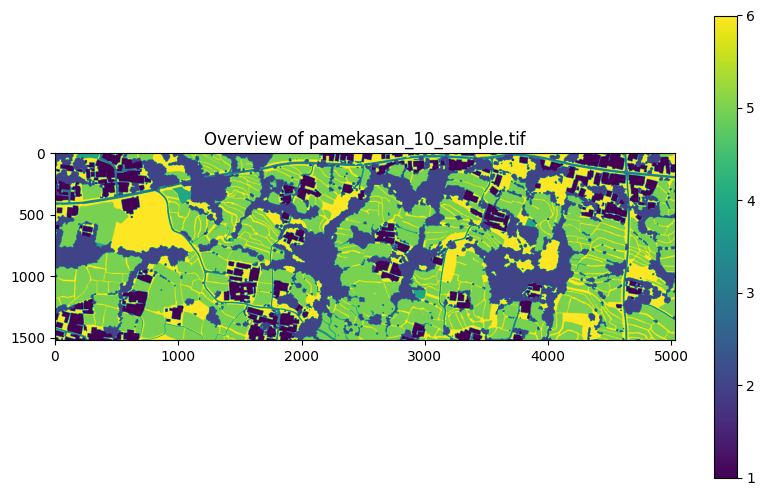

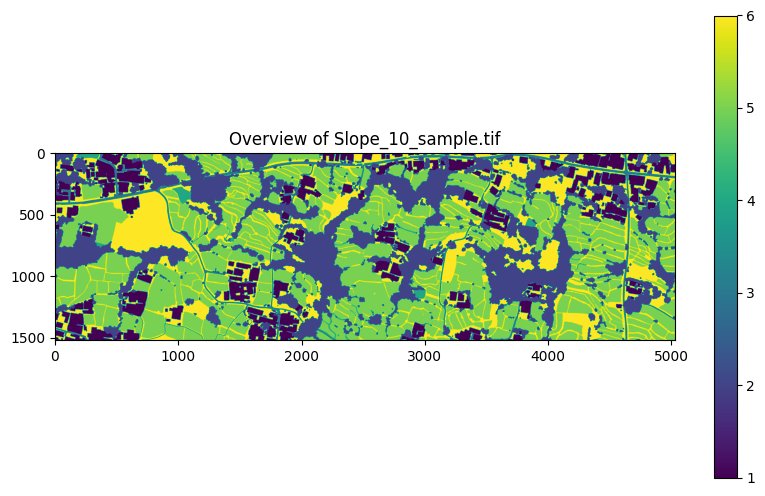

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': 6.0,
  'width': 5028,
  'height': 1517,
  'count': 1,
  'crs': CRS.from_epsg(3857),
  'transform': Affine(0.25, 0.0, 12643736.2353,
         0.0, -0.25, -786100.6562)},
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': 6.0,
  'width': 5028,
  'height': 1517,
  'count': 1,
  'crs': CRS.from_epsg(3857),
  'transform': Affine(0.25, 0.0, 12643736.2353,
         0.0, -0.25, -786100.6562)})

In [1]:
import rasterio
import matplotlib.pyplot as plt

land_cover_path = "pamekasan_10_sample.tif"
slope_path = "Slope_10_sample.tif"

def load_and_inspect_tif(file_path):
    with rasterio.open(file_path) as src:
        metadata = src.meta
        data = src.read(1)
        plt.figure(figsize=(10, 6))
        plt.imshow(data, cmap='viridis')
        plt.colorbar()
        plt.title(f"Overview of {file_path}")
        plt.show()
        
    return metadata, data

# Load and inspect both TIFF files
land_cover_metadata, land_cover_data = load_and_inspect_tif(land_cover_path)
slope_metadata, slope_data = load_and_inspect_tif(slope_path)

land_cover_metadata, slope_metadata

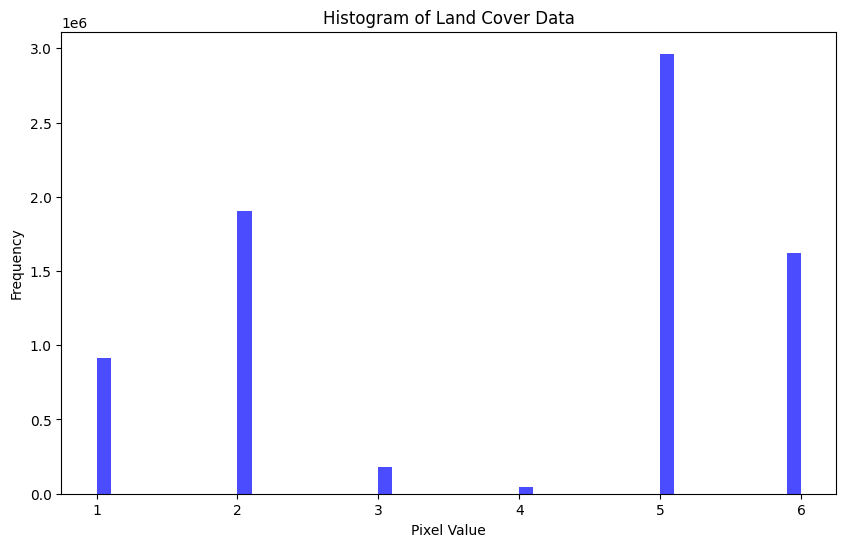

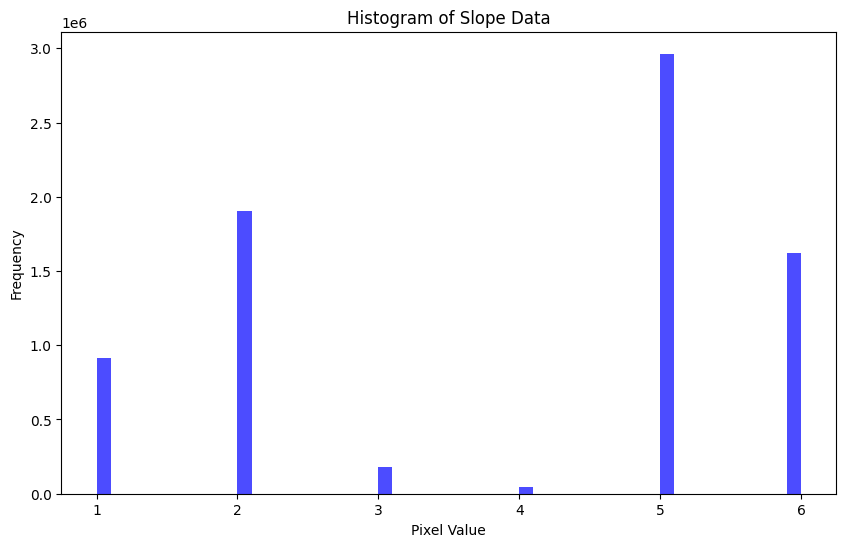

({'mean': 3.9311318,
  'std': 1.8257873,
  'min': 1.0,
  'max': 6.0,
  'unique_values': array([1., 2., 3., 4., 5., 6.], dtype=float32)},
 {'mean': 3.9311318,
  'std': 1.8257873,
  'min': 1.0,
  'max': 6.0,
  'unique_values': array([1., 2., 3., 4., 5., 6.], dtype=float32)})

In [2]:
import numpy as np

def analyze_data(data, title):
    stats = {
        'mean': np.mean(data),
        'std': np.std(data),
        'min': np.min(data),
        'max': np.max(data),
        'unique_values': np.unique(data)
    }
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f"Histogram of {title}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()
    
    return stats

land_cover_stats = analyze_data(land_cover_data, "Land Cover Data")

slope_stats = analyze_data(slope_data, "Slope Data")

land_cover_stats, slope_stats

In [3]:
def print_detailed_metadata(file_path):
    with rasterio.open(file_path) as src:
        return src.tags()

land_cover_tags = print_detailed_metadata(land_cover_path)
slope_tags = print_detailed_metadata(slope_path)

land_cover_tags, slope_tags


({'AREA_OR_POINT': 'Area'}, {'AREA_OR_POINT': 'Area'})

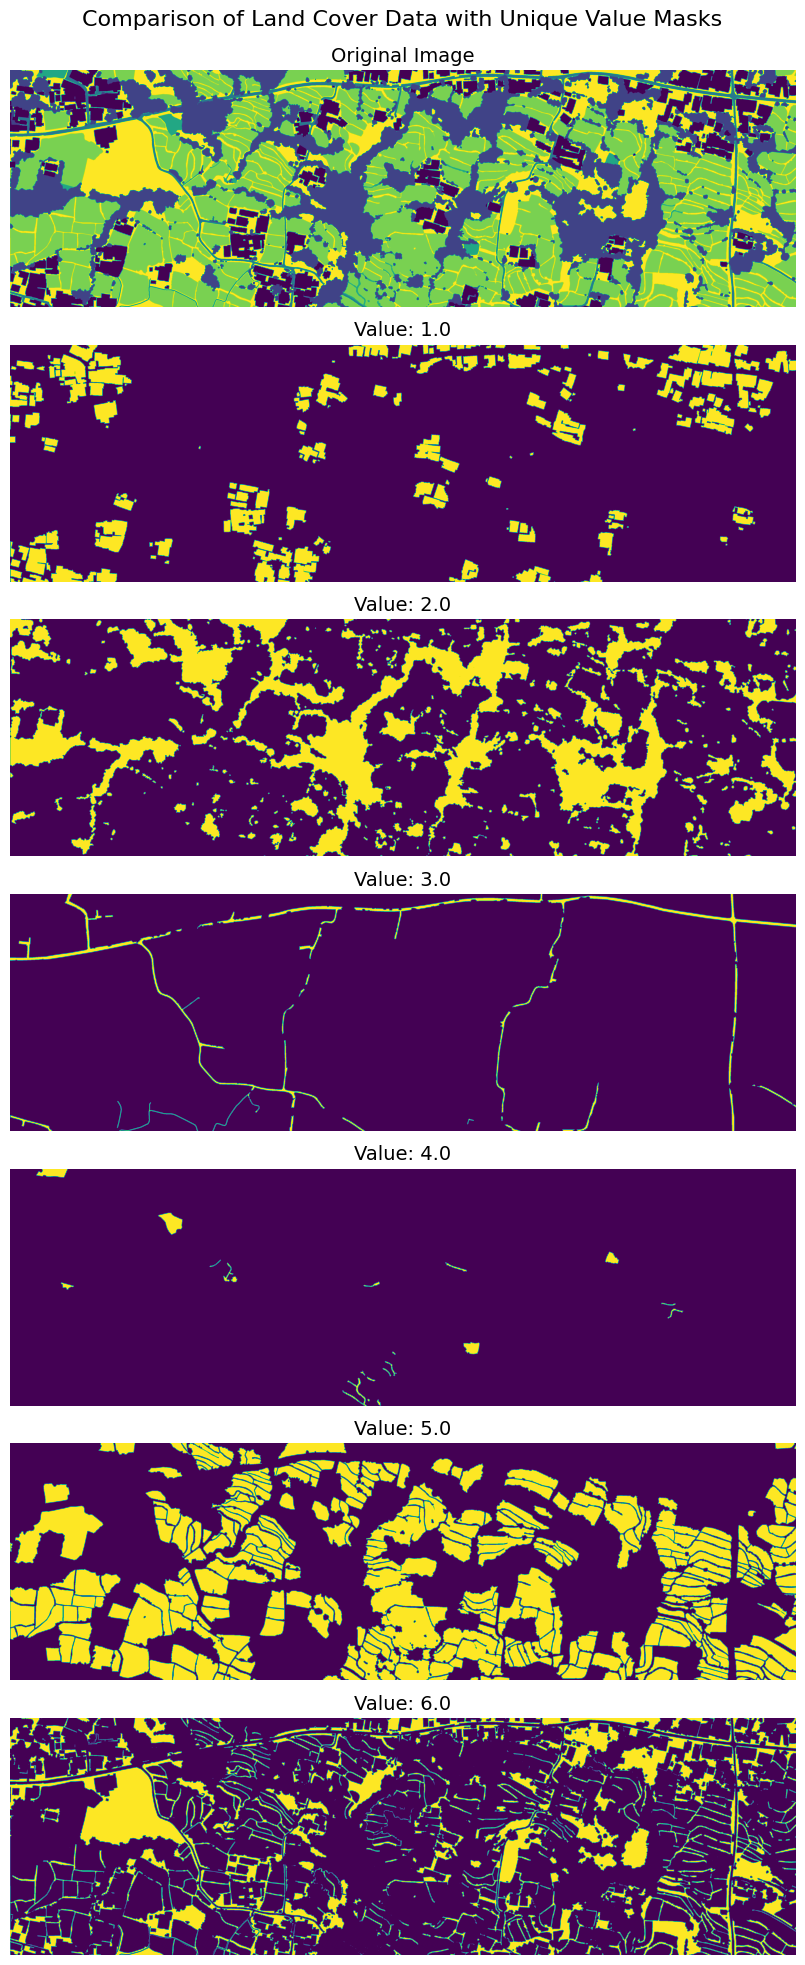

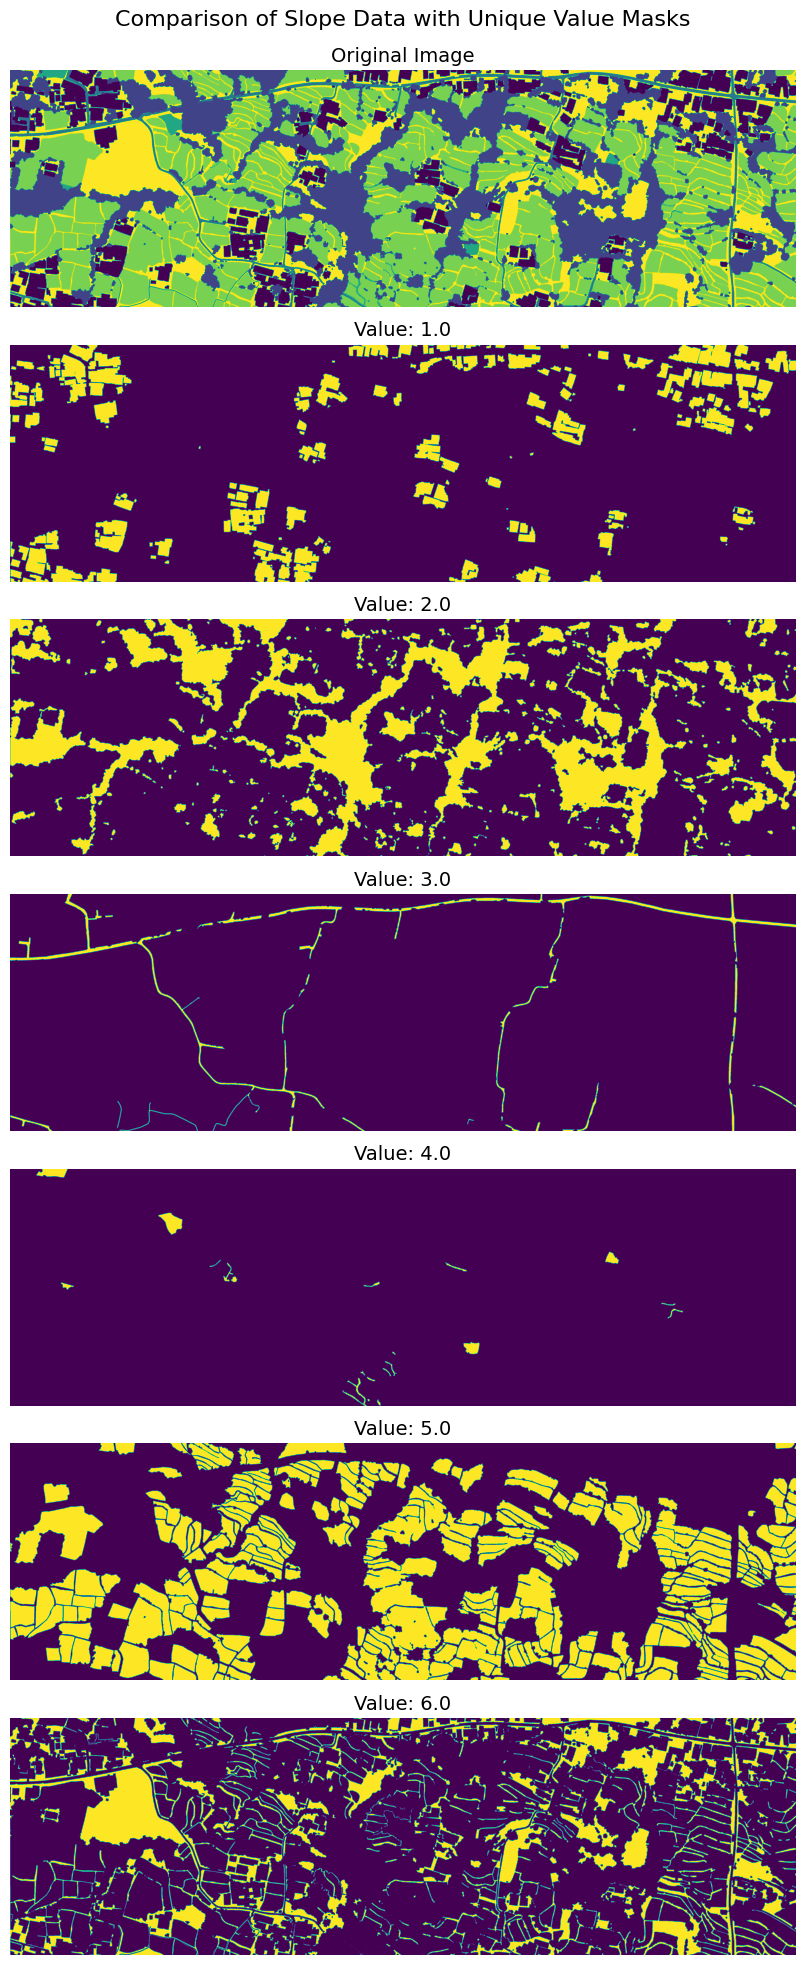

In [4]:
def plot_comparison_with_masks(original_data, title):
    unique_values = np.unique(original_data)
    fig, axes = plt.subplots(len(unique_values) + 1, 1, figsize=(15, 20))
    fig.suptitle(f"Comparison of {title} with Unique Value Masks", fontsize=16)

    # Plot original image
    axes[0].imshow(original_data, cmap='viridis')
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis('off')

    # Plot each unique value mask
    for i, value in enumerate(unique_values):
        ax = axes[i + 1]
        ax.imshow(original_data == value, cmap='viridis')
        ax.set_title(f"Value: {value}", fontsize=14)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Plot comparison for land cover data
plot_comparison_with_masks(land_cover_data, "Land Cover Data")

# Plot comparison for slope data
plot_comparison_with_masks(slope_data, "Slope Data")

In [5]:
patch_size = 256

def extract_patches(image, patch_size):
    patches = []
    img_height, img_width = image.shape
    for i in range(0, img_height, patch_size):
        for j in range(0, img_width, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
    return np.array(patches)

slope_patches = extract_patches(slope_data, patch_size)
land_cover_patches = extract_patches(land_cover_data, patch_size)

In [6]:
def visualize_patches(patches, title, num_patches=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_patches):
        plt.subplot(1, num_patches, i + 1)
        plt.imshow(patches[i], cmap='viridis')
        plt.title(f"{title} Patch {i+1}")
        plt.axis('off')
    plt.show()

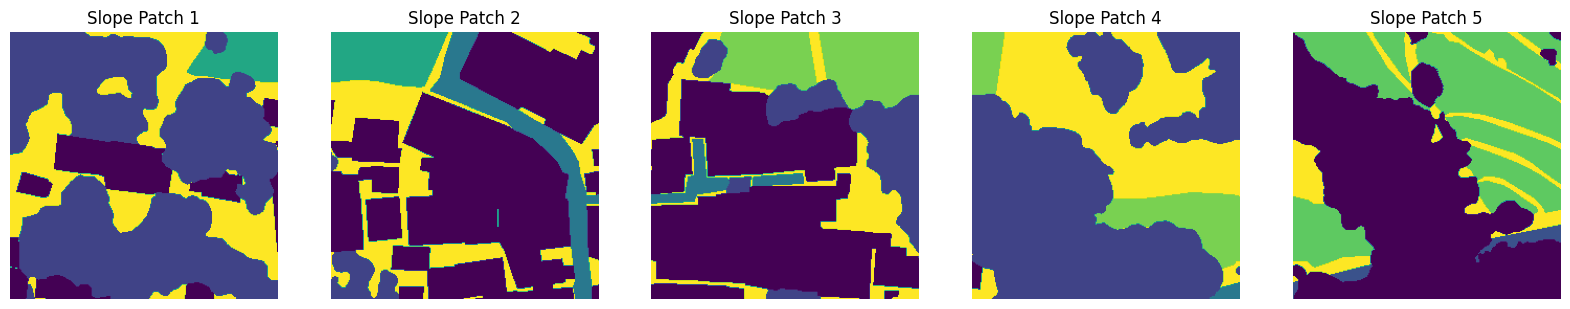

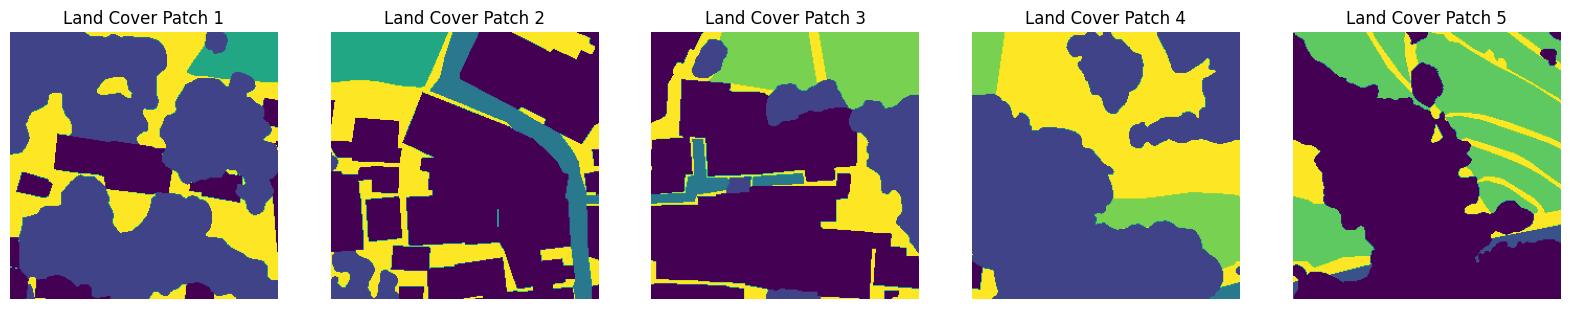

In [7]:
visualize_patches(slope_patches, "Slope", num_patches=5)
visualize_patches(land_cover_patches, "Land Cover", num_patches=5)

In [8]:
slope_patches = slope_patches[..., np.newaxis]
land_cover_patches = land_cover_patches[..., np.newaxis]

In [9]:
from PIL import Image
import os
from sklearn.model_selection import train_test_split
def save_patches_as_images(patches, folder, prefix):
    os.makedirs(folder, exist_ok=True)
    for i, patch in enumerate(patches):
        patch_image = Image.fromarray((patch.squeeze() * 255).astype(np.uint8))
        patch_path = os.path.join(folder, f"{prefix}_{i}.png")
        patch_image.save(patch_path)

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(slope_patches, land_cover_patches, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [18]:
train_slope_dir = "patches/train/slope"
val_slope_dir = "patches/val/slope"
test_slope_dir = "patches/test/slope"

train_land_cover_dir = "patches/train/land_cover"
val_land_cover_dir = "patches/val/land_cover"
test_land_cover_dir = "patches/test/land_cover"

save_patches_as_images(X_train, train_slope_dir, "slope_train")
save_patches_as_images(X_val, val_slope_dir, "slope_val")
save_patches_as_images(X_test, test_slope_dir, "slope_test")

# Save land cover patches as images
save_patches_as_images(y_train, train_land_cover_dir, "land_cover_train")
save_patches_as_images(y_val, val_land_cover_dir, "land_cover_val")
save_patches_as_images(y_test, test_land_cover_dir, "land_cover_test")

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs, outputs)
    return model